In [48]:
from itertools import chain

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import prince
import xgboost as xgb

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import r2_score, accuracy_score, roc_curve, precision_recall_fscore_support

xlsx = pd.ExcelFile( 'media_small.xlsx' )
s1 = pd.read_excel(xlsx,'Summary Correlation - All Stats')
features = [ 'Months on Site Adjusted', 'Average of Quality Leads', 
             'Average of Net Sales', #'Average of Discounts', 
             'Cost Per Lead', 'Average of Unique Clickers', 
             'Average of Unique Senders', 'Average of Unique Requestors', 
             'Average of Unique Callers', 'Average of Unique Viewers' ]
df = s1[~s1['Months on Site Adjusted'].isnull()]
dfm = pd.DataFrame()
dfm['Months on Site'] = df['Months on Site Adjusted']
df_model = df[features]
df_model = df_model.fillna(value=0.0)
df_model = df_model[ df_model.abs() < 4*df_model.mad() ].dropna()
print( df_model.describe() )
df_std = (df_model - df_model.mean())/df_model.std()
df_predict = df_model.copy()
# StandardScaler().fit_transform(df_model) # is another option, but that outputs numpy arrays

#    pc = PCA().fit(df_std)
#    print( '-'*20+'component factor loadings'+'-'*20 )
#    for i,component in enumerate(pc.components_):
#        print( 'Component #{}'.format(i) )
#        for name,loading in zip(df_std.columns,component):
#            print( '\t{}:\t{:.6f}'.format(name,loading) )

# Generate some categorical variables

# Months on site category
labels = np.array('0-6 7-11 12-14'.split())
bins = [-1,6,11,14]
df_std['MOS_category'] = pd.cut(df_model['Months on Site Adjusted'], bins=bins, labels=labels).astype('category')

labels = np.array([0,-1,1])
bins = [-1,11,12,21]
df_predict['MOS_target'] = pd.cut(df_model['Months on Site Adjusted'], bins=bins, labels=labels).astype('category')

# Average of net sales category
pct = df_model['Average of Net Sales'].describe()
bins = [ (pct['min']-1,pct['25%']),
         (pct['25%'],pct['50%']),
         (pct['50%'],pct['75%']),
         (pct['75%'],pct['max']) ]
labels = np.array( [ '{:.1f}-{:.1f}'.format(*bins[0]),
                     '{:.1f}-{:.1f}'.format(*bins[1]),
                     '{:.1f}-{:.1f}'.format(*bins[2]),
                     '{:.1f}-{:.1f}'.format(*bins[3]) ] )


df_std['ANS_category'] = pd.cut(df_model['Average of Net Sales'], bins=[bins[0][0],bins[0][1],bins[1][1],bins[2][1],bins[3][1]], labels=labels).astype('category')

# Average of discounts category
#    pct = df_model['Average of Discounts'].describe()
#    bins = [ (pct['min']-1,pct['25%']),
#             (pct['25%'],pct['50%']),
#             (pct['50%'],pct['75%']),
#             (pct['75%'],pct['max']) ]
#    labels = np.array( [ '{:.1f}-{:.1f}'.format(*bins[0]),
#                         '{:.1f}-{:.1f}'.format(*bins[1]),
#                         '{:.1f}-{:.1f}'.format(*bins[2]),
#                         '{:.1f}-{:.1f}'.format(*bins[3]) ] )
#
#    df_std['ADIS_category'] = pd.cut(df_model['Average of Discounts'], bins=[bins[0][0],bins[0][1],bins[1][1],bins[2][1],bins[3][1]], labels=labels).astype('category')

# Average of cost per lead category
pct = df_model['Cost Per Lead'].describe()
bins = [ (pct['min'],pct['25%']),
         (pct['25%'],pct['50%']),
         (pct['50%'],pct['75%']),
         (pct['75%'],pct['max']) ]

labels = np.array( [ '{:.1f}-{:.1f}'.format(*bins[0]),
                     '{:.1f}-{:.1f}'.format(*bins[1]),
                     '{:.1f}-{:.1f}'.format(*bins[2]),
                     '{:.1f}-{:.1f}'.format(*bins[3]) ] )


df_std['CPL_category'] = pd.cut(df_model['Cost Per Lead'], bins=[-1,bins[0][1],bins[1][1],bins[2][1],bins[3][1]], labels=labels).astype('category')


# Average of quality leads category
pct = df_model['Average of Quality Leads'].describe()
bins = [ (pct['min'],pct['25%']),
         (pct['25%'],pct['50%']),
         (pct['50%'],pct['75%']),
         (pct['75%'],pct['max']) ]

labels = np.array( [ '{:.1f}-{:.1f}'.format(*bins[0]),
                     '{:.1f}-{:.1f}'.format(*bins[1]),
                     '{:.1f}-{:.1f}'.format(*bins[2]),
                     '{:.1f}-{:.1f}'.format(*bins[3]) ] )


df_std['AQL_category'] = pd.cut(df_model['Average of Quality Leads'], bins=[-1,bins[0][1],bins[1][1],bins[2][1],bins[3][1]], labels=labels).astype('category')

# Average of Unique Requestors
bins = np.linspace( 0, 2, 4 )
labels = np.array( [ '{:.1f}-{:.1f}'.format(bins[0],bins[1]),
                     '{:.1f}-{:.1f}'.format(bins[1],bins[2]),
                     '{:.1f}-{:.1f}'.format(bins[2],bins[3]) ] )

df_std['AUR_category'] = pd.cut(df_model['Average of Unique Requestors'], bins=[-1,bins[0],bins[1],bins[2]], labels=labels).astype('category')


# Average of unique viewers category
pct = df_model['Average of Unique Viewers'].describe()
bins = [ (pct['min'],pct['25%']),
         (pct['25%'],pct['50%']),
         (pct['50%'],pct['75%']),
         (pct['75%'],pct['max']) ]

labels = np.array( [ '{:.1f}-{:.1f}'.format(*bins[0]),
                     '{:.1f}-{:.1f}'.format(*bins[1]),
                     '{:.1f}-{:.1f}'.format(*bins[2]),
                     '{:.1f}-{:.1f}'.format(*bins[3]) ] )


df_std['AUV_category'] = pd.cut(df_model['Average of Unique Viewers'], bins=[-1,bins[0][1],bins[1][1],bins[2][1],bins[3][1]], labels=labels).astype('category')

       Months on Site Adjusted  Average of Quality Leads  \
count             18879.000000              18879.000000   
mean                  8.225965                  3.385239   
std                   3.581154                  3.387478   
min                   1.000000                  0.000000   
25%                   6.000000                  0.909091   
50%                   8.000000                  2.375000   
75%                  11.000000                  4.888889   
max                  14.000000                 19.000000   

       Average of Net Sales  Cost Per Lead  Average of Unique Clickers  \
count          18879.000000   18879.000000                18879.000000   
mean             140.074339      74.158967                   17.171558   
std               76.215885      69.663295                   15.393347   
min              -98.554286    -126.712653                    0.000000   
25%               84.926250      25.402569                    5.714286   
50%            

In [42]:
pca = prince.PCA( df_std, n_components=len(features) )
print( '-'*20+'component factor loadings'+'-'*20 )
for i,component in enumerate(pca.svd.V):
    print( 'Component #{}'.format(i) )
    for name,loading in zip(df_std.columns,component):
        print( '\t{}:\t{:.6f}'.format(name,loading) )
        

--------------------component factor loadings--------------------
Component #0
	Months on Site Adjusted:	0.081272
	Average of Quality Leads:	0.443944
	Average of Net Sales:	0.160486
	Cost Per Lead:	-0.270784
	Average of Unique Clickers:	0.416866
	Average of Unique Senders:	0.413765
	Average of Unique Requestors:	0.258984
	Average of Unique Callers:	0.315771
	Average of Unique Viewers:	0.430658
Component #1
	Months on Site Adjusted:	0.269221
	Average of Quality Leads:	-0.050928
	Average of Net Sales:	0.715066
	Cost Per Lead:	0.592616
	Average of Unique Clickers:	-0.049620
	Average of Unique Senders:	-0.020339
	Average of Unique Requestors:	0.207120
	Average of Unique Callers:	-0.074378
	Average of Unique Viewers:	0.105391
Component #2
	Months on Site Adjusted:	0.911982
	Average of Quality Leads:	-0.020666
	Average of Net Sales:	-0.144292
	Cost Per Lead:	-0.093933
	Average of Unique Clickers:	0.026544
	Average of Unique Senders:	-0.034109
	Average of Unique Requestors:	-0.291603
	Average

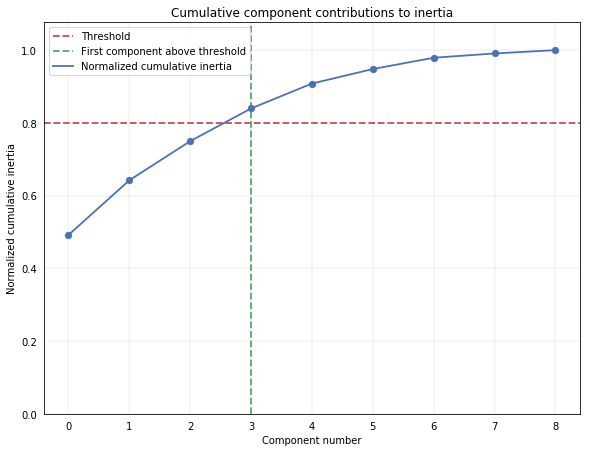

In [43]:
fig1, ax1 = pca.plot_cumulative_inertia()
fig1.savefig('cumulative_inertia.png')
plt.show()

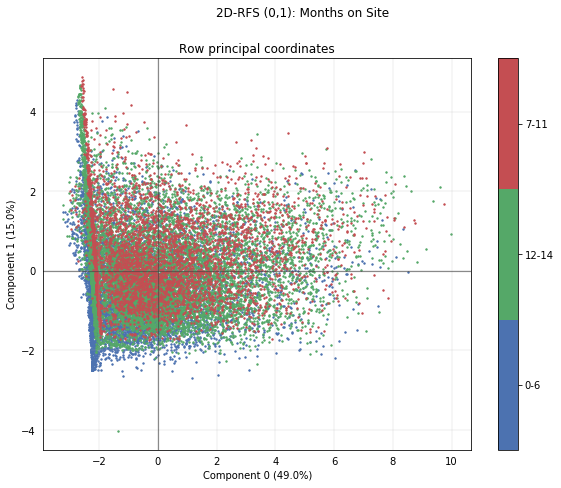

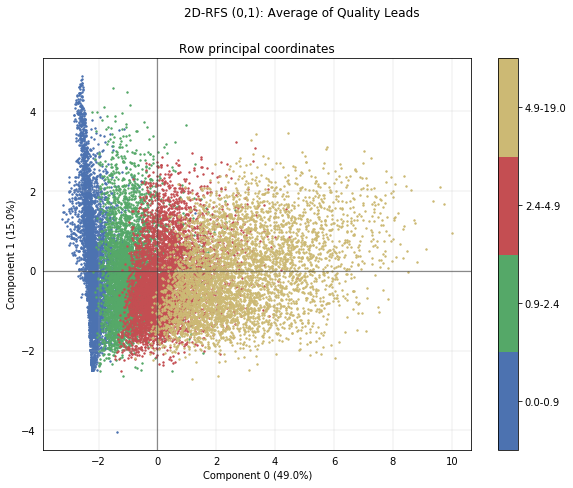

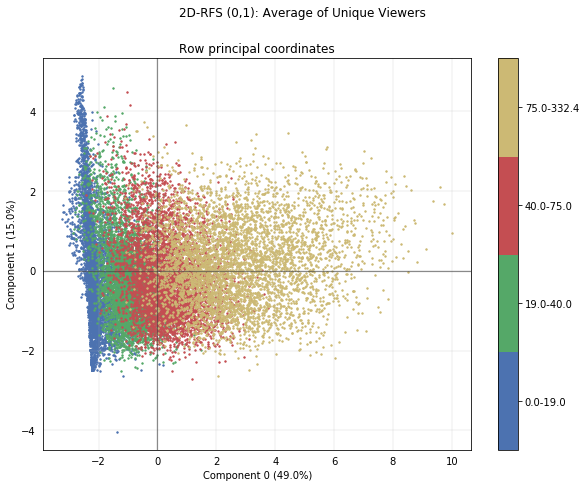

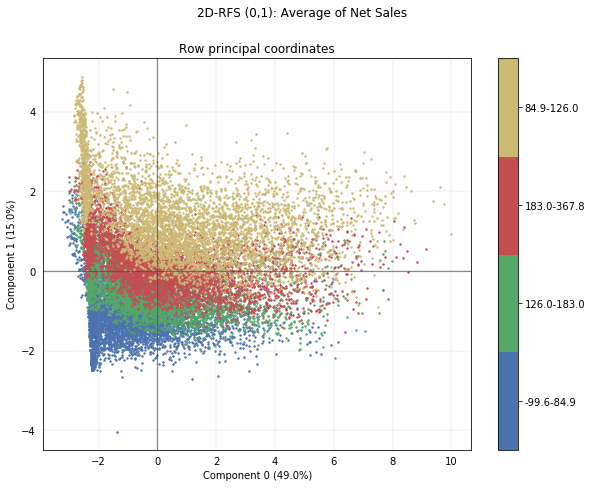

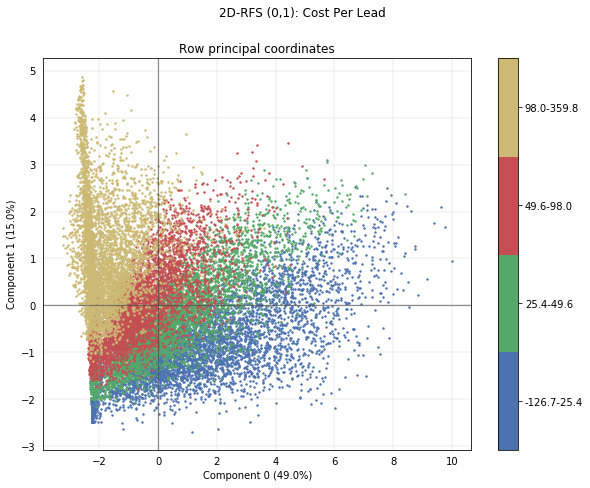

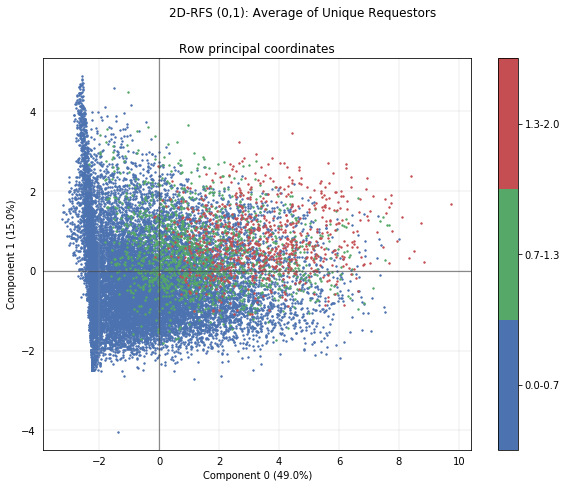

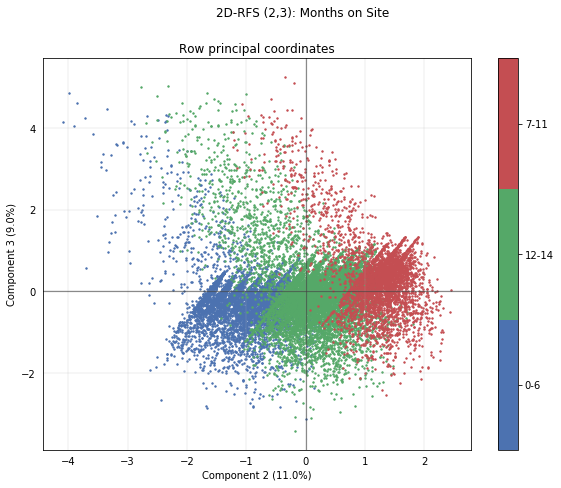

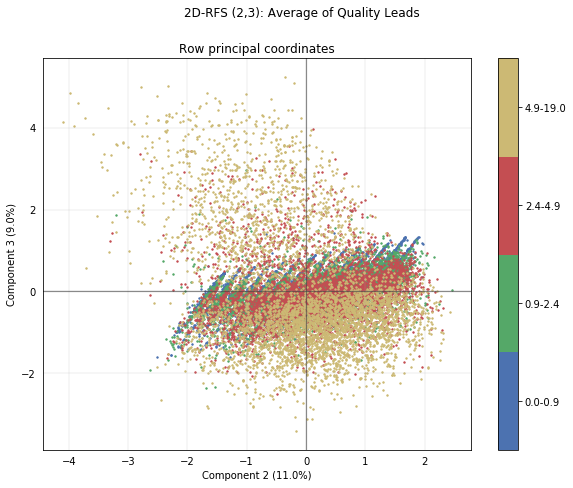

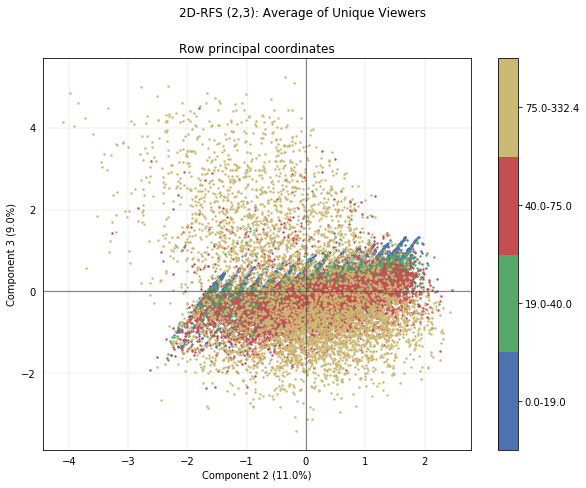

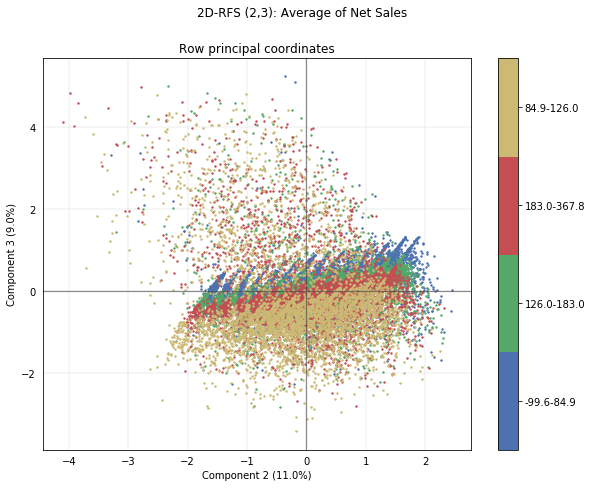

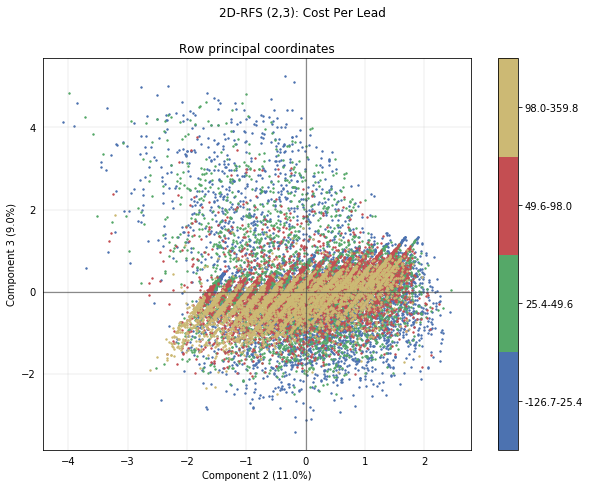

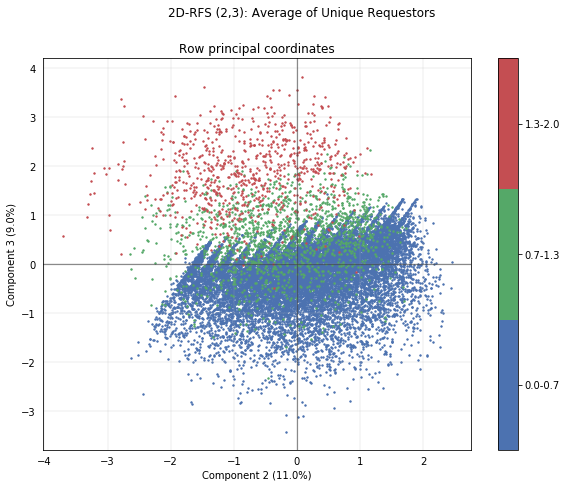

In [44]:
fig2, ax2 = pca.plot_rows( color_by='MOS_category', ellipse_fill=False, dot_size=(2,4) )
fig3, ax3 = pca.plot_rows( color_by='AQL_category', ellipse_fill=False, dot_size=(2,4) )
fig4, ax4 = pca.plot_rows( color_by='AUV_category', ellipse_fill=False, dot_size=(2,4) )
fig5, ax5 = pca.plot_rows( color_by='ANS_category', ellipse_fill=False, dot_size=(2,4) )
fig6, ax6 = pca.plot_rows( color_by='CPL_category', ellipse_fill=False, dot_size=(2,4) )
fig_aur1, ax_aur1 = pca.plot_rows( color_by='AUR_category', ellipse_fill=False, dot_size=(2,4) )

#    figdis, axdis = pca.plot_rows( color_by='ADIS_category', ellipse_fill=False, dot_size=(8,16) )

fig7, ax7 = pca.plot_rows( axes=(2,3), color_by='MOS_category', ellipse_fill=False, dot_size=(2,4) )
fig8, ax8 = pca.plot_rows( axes=(2,3), color_by='AQL_category', ellipse_fill=False, dot_size=(2,4) )
fig9, ax9 = pca.plot_rows( axes=(2,3), color_by='AUV_category', ellipse_fill=False, dot_size=(2,4) )
fig10, ax10 = pca.plot_rows( axes=(2,3), color_by='ANS_category', ellipse_fill=False, dot_size=(2,4) )
fig11, ax11 = pca.plot_rows( axes=(2,3), color_by='CPL_category', ellipse_fill=False, dot_size=(2,4) )
fig_aur2, ax_aur2 = pca.plot_rows( axes=(2,3), color_by='AUR_category', ellipse_fill=False, dot_size=(2,4) )
#    figdis2, axdis2 = pca.plot_rows( axes=(2,3), color_by='ADIS_category', ellipse_fill=False, dot_size=(8,16) )

fig2.suptitle('2D-RFS (0,1): Months on Site')
fig3.suptitle('2D-RFS (0,1): Average of Quality Leads')
fig4.suptitle('2D-RFS (0,1): Average of Unique Viewers')
fig5.suptitle('2D-RFS (0,1): Average of Net Sales')
fig6.suptitle('2D-RFS (0,1): Cost Per Lead')
fig_aur1.suptitle('2D-RFS (0,1): Average of Unique Requestors')
#    figdis.suptitle('2D-RFS (0,1): Average of Discounts')

fig7.suptitle('2D-RFS (2,3): Months on Site')
fig8.suptitle('2D-RFS (2,3): Average of Quality Leads')
fig9.suptitle('2D-RFS (2,3): Average of Unique Viewers')
fig10.suptitle('2D-RFS (2,3): Average of Net Sales')
fig11.suptitle('2D-RFS (2,3): Cost Per Lead')
fig_aur2.suptitle('2D-RFS (2,3): Average of Unique Requestors')
#    figdis2.suptitle('2D-RFS (2,3): Average of Discounts')

fig2.savefig('lead-analysis-assets/mos_factor1-2.png')
fig3.savefig('lead-analysis-assets/aql_factor1-2.png')
fig4.savefig('lead-analysis-assets/auv_factor1-2.png')
fig5.savefig('lead-analysis-assets/ans_factor1-2.png')
fig6.savefig('lead-analysis-assets/cpl_factor1-2.png')
fig7.savefig('lead-analysis-assets/mos_factor2-3.png')
fig8.savefig('lead-analysis-assets/aql_factor2-3.png')
fig9.savefig('lead-analysis-assets/auv_factor2-3.png')
fig10.savefig('lead-analysis-assets/ans_factor2-3.png')
fig11.savefig('lead-analysis-assets/cpl_factor2-3.png')
fig_aur1.savefig( 'lead-analysis-assets/aur_factor1-2.png' )
fig_aur2.savefig( 'lead-analysis-assets/aur_factor2-3.png' )

In [45]:
#    pfeatures = [ i for i in features if i != 'Months on Site Adjusted' and not 'target' in i and not 'category' in i ]
#    pfeatures = [ 'Average of Quality Leads', 'Average of Unique Requestors', 'Average of Unique Viewers', 'Average of Unique Clickers', 
#                  'Average of Unique Senders', 'Average of Unique Callers' ]
pfeatures = [ 'Average of Unique Senders', 'Average of Unique Requestors', 'Average of Unique Callers' ]

# balance the input training samples
df_pos = df_model['Months on Site Adjusted'] > 12
print( 'positives: {}'.format(len(df_model[df_pos])) )
df_neg = df_model['Months on Site Adjusted'] < 9
print( 'negatives: {}'.format(len(df_model[df_neg])) )
num_samples = min( len(df_model[df_pos]), len(df_model[df_neg]) )

pinputs = df_predict[df_pos].sample(num_samples)
ninputs = df_predict[df_neg].sample(num_samples)
inputs = pd.concat( (pinputs,ninputs) ).sample(frac=1)
target = np.array(inputs['MOS_target'].copy())

#    xin = inputs.copy()

inputs = np.array(inputs[pfeatures])
X_train, X_test, y_train, y_test = train_test_split( inputs, target, test_size=0.4 )
y_train = y_train.reshape( y_train.shape[0], 1 )
#    xt = np.hstack((X_train,y_train))

lr = LogisticRegression().fit(X_train,y_train)
print( 'lr intercept: {}'.format(lr.intercept_) )
print( 'lr coefficient: {}'.format(zip(pfeatures,lr.coef_[0].tolist())) )
figpr = plt.figure()
plt.suptitle( 'Probability of renewal as a function of lead type' )
print( '-'*20+'unit increase affecting probability of renewal'+'-'*20 )
for fname, expon in zip(pfeatures,np.exp(lr.coef_[0])):
    print( '{}: {:.2%}'.format(fname,expon-1.0) )
    t = lambda x: lr.intercept_ + np.log(expon) * x
    domain = range(0,100)
    y_range = [ 1.0/(1+np.exp( -t(i) )) for i in domain ]
    plt.plot( domain, y_range, label=fname )
plt.legend(loc='best')
plt.xlabel( 'quantity of lead received' )
plt.ylabel( 'observed probability of renewal' )
plt.savefig( 'probabilty_curves.png' )
    
print( lr.score(X_test,y_test) )
print( '-'*20+'logreg'+'-'*20 )
xt_pred = lr.predict(X_test)
r2 = r2_score( y_test, lr.predict(X_test) )
print( 'R-squared={:.2f}'.format(r2) )
scores = cross_val_score( lr, X_test, y_test, cv=5 )
print( 'accuracy={:.2f}, (+/- {:.2f})'.format(scores.mean(), scores.std()*2) )
scores = cross_val_score( lr, X_test, y_test, cv=5, scoring='f1_macro' )
print( 'F1={:.2f}, (+/- {:.2f})'.format(scores.mean(), scores.std()*2) )

#    fpr, tpr, _ = roc_curve(y_test, lr.predict(X_test))
#    import matplotlib.pyplot as plt
#    plt.figure()
#    plt.plot(fpr,tpr,label='Predict MOS < 12 or MOS > 12')
#    plt.xlabel('False Positive Rate')
#    plt.ylabel('True Positive Rate')
#    plt.show()

positives: 2923
negatives: 9820
lr intercept: [-0.23798628]
lr coefficient: [('Average of Unique Senders', 0.012175637682631264), ('Average of Unique Requestors', 0.21407393040162215), ('Average of Unique Callers', 0.734584197712247)]
--------------------unit increase affecting probability of renewal--------------------
Average of Unique Senders: 1.23%
Average of Unique Requestors: 23.87%
Average of Unique Callers: 108.46%
0.539119281744
--------------------logreg--------------------
R-squared=-0.84
accuracy=0.55, (+/- 0.02)
F1=0.55, (+/- 0.02)


In [46]:
    # try to predict MOS by random forest
xin = df_predict.copy().sample(frac=1)
xin['Months on Site Adjusted'] = xin['Months on Site Adjusted']-1
trainfrac = int(len(xin)*0.6)
X_train = xin[pfeatures].iloc[:trainfrac]
y_train = xin['Months on Site Adjusted'].iloc[:trainfrac]
X_test = xin[pfeatures].iloc[trainfrac:]
y_test = xin['Months on Site Adjusted'].iloc[trainfrac:]
xgb_dmatrix = xgb.DMatrix( X_train, label=y_train )

param = { 'max_depth':30, 'num_class':len(set(xin['Months on Site Adjusted'].values)), 'eta':1, 'silent':1, 'objective':'multi:softmax' }
param['nthread'] = 4
param['eval_metric'] = 'auc'
xgbc = xgb.train( param.items(), xgb_dmatrix )
r2 = r2_score( y_test, xgbc.predict(xgb.DMatrix(X_test)) )
print( '-'*20+'xgboost'+'-'*20 )
print( 'R-squared={:.2f}'.format(r2) )
from xgboost import plot_importance
print( xin[pfeatures].columns )
fig_imp, ax_imp = plt.subplots(figsize=(20,10))
plot_importance(xgbc, importance_type='gain', ax=ax_imp)
fig_imp.savefig('lead-analysis-assets/feature_importance_gain.png')


--------------------xgboost--------------------
R-squared=0.25
Index([u'Average of Unique Senders', u'Average of Unique Requestors',
       u'Average of Unique Callers'],
      dtype='object')


In [47]:
xgbc = GradientBoostingClassifier()
scores = cross_val_score( xgbc, X_test, y_test, cv=5 )
print( 'accuracy={:.2f}, (+/- {:.2f})'.format(scores.mean(), scores.std()*2) )
scores = cross_val_score( xgbc, X_test, y_test, cv=5, scoring='f1_macro' )
print( 'F1={:.2f}, (+/- {:.2f})'.format(scores.mean(), scores.std()*2) )

grd = GradientBoostingClassifier(n_estimators=10)
oh = OneHotEncoder()
lr = LogisticRegression(multi_class='multinomial',solver='lbfgs')
grd.fit(X_train,y_train)
oh.fit(grd.apply(X_train)[:,:,0])
lr.fit(oh.transform(grd.apply(X_test)[:,:,0]),y_test)

predicted_classes = lr.predict( oh.transform(grd.apply(X_test)[:,:,0]))
r2 = r2_score( y_test, predicted_classes )
print( '-'*20+'stacked'+'-'*20 )
print( 'R-squared={:.2f}'.format(r2) )
print( 'accuracy={:.2f}'.format( accuracy_score(y_test,predicted_classes) ) )
precision, recall, fscore, support = precision_recall_fscore_support( y_test, predicted_classes, labels=sorted(set(y_test)) )
for months,(p,r,f,s) in enumerate(zip( precision, recall, fscore, support )):
    print( 'Months on Site={}, P={:.2f}, R={:.2f}, F1={:.2f}, S={}'.format(months+1, float(p), float(r), float(f), s) )


accuracy=0.46, (+/- 0.02)
F1=0.44, (+/- 0.02)
--------------------stacked--------------------
R-squared=-0.55
accuracy=0.16
Months on Site=1, P=0.15, R=0.70, F1=0.25, S=322
Months on Site=2, P=0.33, R=0.01, F1=0.01, S=322
Months on Site=3, P=0.00, R=0.00, F1=0.00, S=323
Months on Site=4, P=0.00, R=0.00, F1=0.00, S=317
Months on Site=5, P=1.00, R=0.00, F1=0.00, S=449
Months on Site=6, P=0.06, R=0.00, F1=0.00, S=543
Months on Site=7, P=0.15, R=0.81, F1=0.25, S=962
Months on Site=8, P=0.19, R=0.19, F1=0.19, S=738
Months on Site=9, P=0.00, R=0.00, F1=0.00, S=673
Months on Site=10, P=0.22, R=0.05, F1=0.08, S=684
Months on Site=11, P=0.00, R=0.00, F1=0.00, S=591
Months on Site=12, P=0.00, R=0.00, F1=0.00, S=461
Months on Site=13, P=0.36, R=0.01, F1=0.01, S=746
Months on Site=14, P=0.00, R=0.00, F1=0.00, S=421


# Table of Contents
1. [Executive Summary](#Executive-Summary)
2. [Methodology](#Methodology)
3. [Factor Analysis](#Factor-Analysis)
4. [Linear Modeling](#Linear-Modeling)
5. [Formulas](#Formulas)

## Executive Summary

Factor analysis and linear modeling were performed on a projection of storefront leads/traffic/sales data.  Several interesting insights have been obtained which can be confirmed and perhaps improved on by a follow-on effort to acquire more and different data.  The following results are most relevant:

* A unit increase in the average of quality leads (Non-VRT Senders + Callers + Tour Requestors) results in a 1-3% increase in the odds that a vendor will be part of the group that renews
* A unit increase in the average of tour requests results in a 19-22% increase in the odds that a vendor will be part of the group that renews
* A unit increase in the average of callers results in a 67-69% increase in the odds that a vendor will be part of the group that renews

![Figure: Probability as a function of lead type](lead-analysis-assets/probabilities.png)


While these results are statistically significant and reflect phenomena truly present in the data, a word of dilligence should be made regarding the source inputs.  Each of the inputs that we modeled were aggregated and averaged over a period of time.  When doing this, much of the variability in the data is smoothed out so that we lose some information.  For example, when considering something like average leads per month as it relates to the renewal rate, it is entirely conceivable that leads received in a particular month (the peak month for a certain vendor) has some net impact on that vendor's likelihood of renewing.  Two averages could be identical therefore, but reflect leads received in different months, where the time of year they were received is important to the vendors.  I recommend a follow-on analysis with data as raw and granular as possible to corroborate and enhance these findings.


## Methodology


Our input data consists mostly of averages relating storefront views, leads, and cost/sales over a period of time ranging from 1/16 to recently this year.  It also contains a lot of blank entries, particularly for columns like the 'discounts' field, which make analysis problematic.  There are 30,350 total rows.  Around 3K of these, however, early in 2016, have an incorrect number in the 'Months on Site Adjusted' field due to migration from CES to Salesforce, which ostensibly reset that value.  These were dropped from the analysis.  Also dropped were very extreme outliers.  In general, with the kind of analysis that will follow, you want a more permissive definition of outlier because centrality offers very little information and near-inliers represent large moves away from the mean which generally gives you a big clue about what the factors represent.  It's good to drop extreme cases, though, because they can distort the mean centering required by PCA, since the mean isn't a robust estimator.

Each row (sample) in the sheet represents a vendor storefront with the following features with averages of whatever thing it is per month.  So something like "Cost Per Lead" is average monthly cost per lead.

Months on Site Adjusted

Average of Quality Leads

Average of Net Sales

Cost Per Lead

Average of Unique Clickers

Average of Unique Senders

Average of Unique Requestors

Average of Unique Callers

Average of Unique Viewers

Given that the data, with the exception of _Months on Site Adjusted_ consists of averages and each average corresponds to a particular sample, our data is, by the CLT, _multi-variate gaussian_.  It makes sense then to use principal component analysis (PCA) as an efficient means to identify and explain the shape and variability of the data.

I will take the following approach:

1.  PCA on spreadsheet leads data
2.  Linear prediction on spreadsheet leads data

It is often useful to complete PCA prior to performing linear prediction for two primary reasons.  First, PCA gives us a way to reason about the primary sources of variability in our data..why our data is the way it is.  Since PCA is linear in nature, when we consider the linear prediction that will follow, it is a reasonable starting point.  Second, PCA often gives us a good feel for what variables are highly correlated.  It seems clear from the above list that _Clickers_ and _Viewers_ are likely highly correlated as are many of the rest.  This correlation can cause instability in our estimation of our regression coefficients that will need to be handled.


## Factor Analysis


Recall, that in PCA we are looking for some set of underlying factors that explain the majority of the variation in the data.  A linear component is some weighted, linear combination of the input variables that is highly correlated with one of these latent factors.  When data is highly correlated, it is usually the case that some smaller number of variables can explain the majority of the variation in the data in the same way that the rank of a matrix is less than the dimension when rows are linear combinations.  We call these linear combinations the _components_.  We find the correlation coefficients of each variable to these components and we compute the inner product of this component and our standardized variable values.  For some storefront X:

$$Factor Score_{X}=\sum_{i=1}^{n} standardized variable_{X_{Vi}} * loading_{Vi}$$

Since an inner product can be thought of as a translation of one matrix into the space where the other matrix is the basis, $FX$ can be thought of as a translation of the variable matrix $X$ into the space where the factor matrix $F$ is the basis.

We solve for these components in one of two ways:

1.  Perform eigendecomposition on the covariance matrix of our unstandardized data
2.  Perform Singular Value Decomposition (SVD) on the standardized data matrix

Both of these techniques are equivalent and produce a set of eigenvalue/eigenvector pairs where the magnitude of the eigenvalues is proportional to the fraction of variance explained by that eigenvector.  We order the factors by the percent of the variation that each explains, from most to least.  If many of the input variables are correlated and carry a lot of mutual information, we expect that some smaller number of factors would explain the data perhaps just as well.  This is exactly what we see with this data.  In our case, we have 9 input variables, and we can see the percent of variance explained by the first 9 components in Figure 1.


![Figure 1:  Cumulative Inertia](lead-analysis-assets/cumulative_inertia.png)


Notice that the first 4 components in Figure 1 explain around 85% of the variance (inertia) in the data.  The returns start to diminish above the 4th component.  What we seek is an explanation for what underlying factor the first 4 components represent.  We can begin to reason about this in two ways:
  
  1.  Looking at the factor loadings.
  2.  Observing the row factor score plots.

Let's start by looking at the loadings for the first component:


>Component #0

>Months on Site Adjusted: 0.081272

>Average of Quality Leads: 0.443944

>Average of Net Sales: 0.160486

>Cost Per Lead: -0.270784

>Average of Unique Clickers: 0.416866

>Average of Unique Senders: 0.413765

>Average of Unique Requestors: 0.258984

>Average of Unique Callers: 0.315771

>Average of Unique Viewers: 0.430658
 

Recall that this data has been mean centered with unit variance.  This is important for two reasons.  First, principal component methods generally deal with clouds of informational masses where the use of language like 'mass', 'inertia', 'moment of inertia', 'barycenter' taken from classical mechanics is quite deliberate.  There are direct analogs to these concepts, and in fact, much of the math is identical.  As such, it is useful to have the data mean centered so that we can reason about things being at the origin (near the mean), or away from the origin much the same way we would reason about a center of mass.  We also standardize the data so that it has unit variance.  This is because, since we are looking for a linear component that explains the majority of the variation in the data, guess what would happen if one of the variables had a large variance to begin with?  It would dominate the loadings and we would lose the intra-variable relationship we were looking for.  So, observing the loadings for component #0 above, we note a few things:

1.  Most of them are positive.
2.  Many of them are very close.
3.  Cost Per Lead moves in the opposite direction of "Average of Quality Leads" as well as the quintet of vendor contact that follows.
4.  Months on Site Adjusted doesn't play much of a role in this component.

This already tells us a few things.  For one, the loadings around the ~0.4 mark are all highly correlated.  This corroborates a conclusion we came to early on by observing the correlation cross-tab in Marci's spreadsheet.  Also, consider what an above average number of leads/views/clicks etc. would do to the factor score.  It would likely be a large value unless the cost per lead was extremely high relative to the average, where the negative weight would bring the factor score down.  Let's confirm some of this by looking at a couple of row-factor score plots colored by some of the variables.  Here, I will make the same 2D scatterplot of the storefront row-factor scores on the first and second principal components, but I will color them in different ways.  I start by coloring the plot by the range (quartile) that the average of quality leads each sample falls within in Figure 2.  Keep in mind that the mean of "Average of Quality Leads" is ~3.4 in this plot.

![Figure 2: Average of Quality Leads on components 0 and 1](lead-analysis-assets/aql_factor1-2.png)

So the gold values represent a much higher quality of leads total relative to the average of 3.4.  We expect a similar coloring scheme where the high numbers are on the right side with the remainder of the variables that are highly correlated with leads.  For example, Figure 3.

![Figure 3: Average of Unique Viewers on components 0 and 1](lead-analysis-assets/auv_factor1-2.png)


Now, take a look at Figure 4 which is colored based on the Cost Per Lead, which averages 74.15.

![Figure 4: Cost Per Lead on components 0 and 1](lead-analysis-assets/cpl_factor1-2.png)

Notice that a below average value in Cost Per Lead would lead to a standard score that was negative, which, when multiplied by the negative loading from above produces a large score and a point which lands far to the right of this graph.  The coloring bears this out as well.  Also interesting is the diagonal coloring apparent with Cost Per Lead, which implies that CPL heavily impacts not only the x axis:  the first component, but also the y axis:  the second component.  We'll see this below.

So, it seems reasonable to conclude that the first component illustrates a contrast between those samples where both the user activity to the vendor is high and the cost to the vendor is low with those samples where the user activity is low, but the vendor cost is high.  In other words, the first component opposes those vendors for whom our traffic provides a good value and those for whom we provide less value.

**Inference #1:  The first component models our value to the vendor**

Let's just double-check this once more by looking at the same plot, but colored by the number of tour requests.  If the first component most closely modeled our value to the vendor, what should we expect?  We would expect that the highest number of tour averages would be on the right side of the plot and the lower number on the left.

![Figure 5: Average of Unique Requestors on components 0 and 1](lead-analysis-assets/aur_factor1-2.png)

Now, if the first component is the one that separates the data based on the value we provide, it seems like everyone's initial idea is that this is strongly related to the months on site.  We already know that this is not the case based on the fact that the factor loading is close to zero for this component.  Let's just confirm visually by coloring the same plot, but by months on site.

![Figure 6: Months on Site on components 0 and 1](lead-analysis-assets/mos_factor1-2.png)

That's kind of what we expected.  Some vendors have a long tenure and get little value, some have a long tenure and get lots of value and vice versa.  There does seem to be a little bit (0.081272 in fact) of the value effect on tenure because there are far more blues (Below average months on site) on the left side of the graph where our value is low to the vendor than on the right where it is high.  But it isn't the most important explanatory factor.

What about the second component, the Y axis above?  Let's take a look at the factor loadings:


>Component #1

>Months on Site Adjusted: 0.269221

>Average of Quality Leads: -0.050928

>Average of Net Sales: 0.715066

>Cost Per Lead: 0.592616

>Average of Unique Clickers: -0.049620

>Average of Unique Senders: -0.020339

>Average of Unique Requestors: 0.207120

>Average of Unique Callers: -0.074378

>Average of Unique Viewers: 0.105391

Now that we know generally how to think about these factors, let's remove the factors closest to zero and split the high magnitude factors into groups on a line (Figure 7).


![Figure 7](lead-analysis-assets/single_axis.png)

This component would seem to oppose storefronts into these two general groups:

Group #1:  Storefronts that pay us a lot of money, may or may not get a lot of leads depending on component 0 position in the last analysis, who generally have an above average tenure and who get a lot of member requests for tours.

Group #2:  Storefronts that don't pay us as much, don't get a lot of requests for quotes, may or may not stay on the site, and generally get a lot of the "light" interaction traffic: clicks, sends, calls, but not a lot of member requests for tours.

This component seems to be indicative of some deeper level of engagement on the part of both users who are more intentional about their storefront interaction (tour requests vs clicks and views) and vendors who are willing to shoulder a higher financial burden for this interaction.  This is also evident from the scatterplot colored by "Average of Unique Requestors" above.  Consider that, in that plot, very few reds fell below the x axis.  Here it is again in Figure 8 just for review.

![Figure 8: Average of Unique Requestors on components 0 and 1](lead-analysis-assets/aur_factor1-2.png)

This leads us to the following:

**Inference #2:  The second component models heavy site utilization both on the part of vendors who have above average net sales and on the part of their users who initiate a larger number of tour requests.**

Now, onto the third and fourth components (component #2 and component #3 by convention):


Component #2
Months on Site Adjusted: 0.911982
Average of Quality Leads: -0.020666
Average of Net Sales: -0.144292
Cost Per Lead: -0.093933
Average of Unique Clickers: 0.026544
Average of Unique Senders: -0.034109
Average of Unique Requestors: -0.291603
Average of Unique Callers: 0.194447
Average of Unique Viewers: -0.116227

 
Component #3
Months on Site Adjusted: 0.261456
Average of Quality Leads: -0.095921
Average of Net Sales: -0.277203
Cost Per Lead: -0.155854
Average of Unique Clickers: -0.241360
Average of Unique Senders: -0.195075
Average of Unique Requestors: 0.810609
Average of Unique Callers: -0.215542
Average of Unique Viewers: 0.146466 
 

![Figure 9: Months on Site on components 2 and 3](lead-analysis-assets/mos_factor2-3.png)

This one is a bit more difficult to interpret.  On the one hand, the majority of the loading for component #2 comes from the months on site being above average.  Given that the mean of "Months on Site Adjusted" is 8.23, it makes sense that green values are generally to the right of the origin, but it's a bit confusing that the red section, which appears to be more average, is generally not closer to the origin.

We can do something tricky here and use the reflection of this component by imagining that we rotated the data 180 degrees.  With this transformation, the loadings become:

>Component #2

>Months on Site Adjusted: -0.911982

>Average of Quality Leads: 0.020666

>Average of Net Sales: 0.144292

>Cost Per Lead: 0.093933

>Average of Unique Clickers: -0.026544

>Average of Unique Senders: 0.034109

>Average of Unique Requestors: 0.291603

>Average of Unique Callers: -0.194447

>Average of Unique Viewers: 0.116227

Now, we can see that a below average months on site, coupled with an above average value in both net sales and tour requests would push a storefront to the right on this plot.

**Inference #3:  The third component opposes storefronts that have short tenure but pay a lot for a slightly above average number of tour requests with storefronts that have a long tenure, low net sales, and a low number of tour requests**

The fourth component (component #3) appears to be most strongly related to the number of tour requests:

![Figure 10: Average of Unique Requestors on components 2 and 3](lead-analysis-assets/aur_factor2-3.png)

Again, this component appears to reflect more of the same phenomenon that is evident throughout the data; namely, some storefronts extract a lot of net value from the site, and some don't.

>Component #3

>Months on Site Adjusted: 0.261456

>Average of Quality Leads: -0.095921

>Average of Net Sales: -0.277203

>Cost Per Lead: -0.155854

>Average of Unique Clickers: -0.241360

>Average of Unique Senders: -0.195075

>Average of Unique Requestors: 0.810609

>Average of Unique Callers: -0.215542

>Average of Unique Viewers: 0.146466 

Looking at these loadings, it seems to oppose storefronts that receive above average tour requests, have a slightly higher months on site, pay a lot less per lead and get a lot of traffic in general.

**Inference #4:  The fourth component opposes storefronts that receive a higher number of tour requests and pay a below average rate from those that have a low number of tour requests but pay a high average rate.**

## Linear Modeling

Two general approaches will be taken when modeling renewal rate:

1. A gradient boosting classifier will be trained to target the months on site for a vendor.
2. A logistic regression model will be trained to discriminate between vendors who stay < 12 months from those that stay > 12 months.

The first approach will give us a metric on the information gain from each variable in predicting vendor tenure.  This will inform the construction of the model in the second approach, which will give us the rate at which the probability of renewal changes with respect to the input variables.

Here is the informativity of each feature for task 1 above:

![Figure 11: Feature importance in predicting actual months on site](lead-analysis-assets/fimportances.png)

This 'feature importances' graph indicates the relative importance of all features including sales data in predicting the actual number of months that a vendor remained on our site, i.e. 7, 8, 10, 14, etc.  Notice that the sales data tracks the months so well that it dominates the information.  For the question about renewals, which is really the one we want to answer, we have to distinguish between vendors who didn't renew or outright cancelled (months on site < 12) and vendors who did renew (months on site > 12).  I exclude months on site strictly == 12 with this range.  We also drop the sales data as predictors for this model for the aforementioned reasons.  Also, the previous feature importance graph is a measure of the number of times a feature appears in the resulting forest of estimators in a gradient boosting classifier.  Most of the time, this ordering is different from the information gain per feature.  Here is the specific information gain per feature for the same months on site prediction model that excludes sales data which is most closely representative of the linear model and for which I give results and draw the conclusions:

![Figure 12: Feature information gain in predicting renewal](lead-analysis-assets/feature_importance_gain.png)

You can see callers and requestors provide the greatest information gain in this model, and again callers is tremendously informative.

The PCA analysis gives us a technical means by which we can test the assertion that the relationship between quality leads and renewal (months on site > 12) is the one that explains the majority of variation in the data, namely component #0.  From the previous analysis, we can see that this is not the case.  We saw that there is some of what I termed the "value effect" on months on site, but it is relatively low in this data.  It isn't until the 3rd component that we begin to see strong separation between vendors based on tenure, and this component is already at the diluted explanation of variance level.

For the specific answer we are seeking, we already know from the PCA that the particularly strong relationship between quality leads and months on site isn't present in the data, while there does seem to be a stronger relationship between our sales and cost per lead and tenure.  This gives us a clue that any predictor built on this input will likely model the strong relationship between net sales and tenure.  The strength of this relationship in the data makes sense because people who stay longer pay us more, but it's not incredibly useful for driving net sales.  Rather, it's like saying, "If you want people to stay longer and give you more money, try to drive up the length of time they stay and the amount of money they give you."  This is, in fact what we see when we attempt to build a predictor that determines whether a vendor extends the contract period or not.

You can from the first chart that the biggest predictors are, as expected, the features that are most closely related to the months on site, namely, the ones that simply track months on site as a function of the dollars spent with us.  So the only real way to proceed is to drop the most informative features.  We can then expect that our predictive accuracy will drop considerably, but we will also be focusing on the things we can attempt to control here:  leads.

We will use logistic regression to solve for the probabilities of months on site < 12 and months on site > 12.  Our independent variables will be the tuple (Average of Quality Leads, Average of Unique Callers, Average of Requestors).

Regarding predictive accuracy, the following are the numbers I am able to generate using a linear model:

Predict the actual number of months on site given all of the quality leads related inputs, excluding sales data:
Accuracy: 45%
R-squared: 0.11

R-squared at 0.11 means we can only explain 11% of the variance in months on site with all of the quality leads data.

Predict whether the vendor will have a months on site greater than or less than 12:
Accuracy: 55%
F1: 0.55 +/- 0.02
R-squared is not a meaningful measure here as the data is binary.

Since the input data to this binary prediction case: renewal vs non-renewal are balanced, the naive prediction (a pure guess) would yield results close to 50%.  We are able to do a bit better than this, but not by much.

We know there is a lot of correlation among these features and quality leads, which means the estimates that any predictive model provides will change based on which correlated features are included, but this perhaps offers some insight.  In other words, don't be too married to the specific numbers, but the relative relationship among them should hold:

When we predict renewal based on Average of Quality Leads and Average of Unique Requestors, a unit increase in Average of Quality Leads, that is 1 additional point in this average, is associated with a 1-3% increase in the odds of renewal.  A unit increase in Average of Unique Requestors is associated with a 19-22% increase in the odds of renewal.

When we predict renewal including Average of Unique Callers in the independent variables, we find that a unit increase in Average of Unique Callers is associated with a 67-69% increase in the odds of renewal.

Based on this, and making the huge presumption that this observed effect is causative in nature, I would say the following would be a reasonable strategy:

If you want to really make vendors renew their contracts, get more members to call them.  For every 1 point change in this average there is a corresponding 67-69% increase in the odds that a vendor is part of the group that renews.

You can then get more members to request tours.  For every 1 point change in this average there is a 19-22% increase in the odds that a vendor is in the group that renews.

If you increase Average of Quality Leads in general, each 1 point increase in this average is associated with a 1-3% increase in the odds that a vendor is in the group that renews.


## Formulas

Logistic regression is a linear modeling technique in which we associate the log-odds with a linear function on N input variables:

$$log(\frac {P} {1-P}) = \beta + \sum_{i=1}^{N}w_ix_i$$

where $\beta$ is our intercept term and $\sum_{i=1}^{N}w_ix_i$ is generally referred to as $t$.  With some derivation, using this formulation we can arrive at the following to find the probability:

$$\frac{1}{1+e^{-t}}$$

To compute the effect that a unit change in a particular predictor has on the resulting odds using this model, calculate:  

$$e^{weight}-1$$

For example, $e^{0.51} - 1 = 0.66529$ which is where the 67-69% figure above comes from.

Let t be the result of the linear model:

$t=-1.21+0.02*Average of Quality Leads+0.51*Average of Unique Callers+0.21*Average of Unique Requestors$

Then the probability can be found by:

$$\frac{1}{1+e^{-t}}$$

For example, A given vendor has received no quality leads, no calls, no tour requests.  What is the probability that they will renew?

$$\frac{1}{1+e^{-(-1.21+0.02*0+0.51*0+0.21*0)}} = 0.2294 = 22.94\% $$ 

....which is simply the marginal probability of renewal from the data I used to train:

_2923 renewals_

_9820 cancellations_

_2923/(2923+9820) = 0.22938_

This is what $\beta$ is above in logistic regression:  the intercept that gives the marginal probability when the input variables are all 0.

Say a vendor gets 10 quality leads, 1 call and 0 requests:



$$\frac{1}{1+e^{-(-1.21 + 0.02 * 10 + 0.51 * 1 + 0.21 * 0}} = 0.377 = 37.7\%$$



Here's a graph that shows probability of renewal as a function of a unit increase in the various predictors:


![pcurves](lead-analysis-assets/probabilities.png)